# Demo No. 12 - Light curve fitting.

This demo will guide you trough a process of inferring a parameters of the eclipsing binary from the shape of the light curve. We will stat again by importing necessary modules and setting our loging:

In [1]:
import os

import astropy.units as u

from elisa.conf import config
from elisa.analytics import LCData
from elisa.analytics import BinarySystemAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging() 

In this particular case of KIC 4851217, we will help ourselves by using previous results obtained from radial velocity fit. In particular, radial velocities are much more sensitive to mass ratio of the components, therefore we will adopt the value obtained in previous demo and we will keep it fixed. 

The procedure itself is very similar to the one mentioned in the previous demo 11. Initially, we will initiate the dataset with our Kepler phase curve:

In [2]:
kepler_data = LCData.load_from_file(filename='demo_data/lc_data/kepler_phs_crv.dat', 
                                    x_unit=u.dimensionless_unscaled, 
                                    y_unit=u.dimensionless_unscaled
                                   )

This will be followed by initialization of `BinarySystemAnalyticsTask`, where light curves are provided as values of dictionary with filter names as their corresponding keys:

In [3]:
task = BinarySystemAnalyticsTask(light_curves={'Kepler': kepler_data})

Similarly to rv_fit module, we can also pick from `standard` and `community` approach. We can acces lists of available parameters in a similar fashion:

In [4]:
task.lc_fit.FIT_PARAMS_COMBINATIONS

{'standard': ['p__mass',
  's__mass',
  'inclination',
  'eccentricity',
  'argument_of_periastron',
  'period',
  'primary_minimum_time',
  'p__t_eff',
  's__t_eff',
  'p__surface_potential',
  's__surface_potential',
  'p__gravity_darkening',
  's__gravity_darkening',
  'p__albedo',
  's__albedo',
  'additional_light',
  'phase_shift'],
 'community': ['mass_ratio',
  'semi_major_axis',
  'inclination',
  'eccentricity',
  'argument_of_periastron',
  'period',
  'primary_minimum_time',
  'p__t_eff',
  's__t_eff',
  'p__surface_potential',
  's__surface_potential',
  'p__gravity_darkening',
  's__gravity_darkening',
  'p__albedo',
  's__albedo',
  'additional_light',
  'phase_shift']}

Using this dictionary, we can define our starting parameters:

In [5]:
lc_initial = {
    'inclination': {
        'value': 81.0,
        'fixed': False,
        'min': 79,
        'max': 83
    },
    'eccentricity': {
        'value': 0.01,
        'fixed': False,
        'min': 0.00,
        'max': 0.05,
    },  # value obtained during RV fit but kept variable due to poor coverage of RV measurements and sensitivity of LC 
        # on eccentricity
    'mass_ratio': {
        'value': 1.077,
        'fixed': True,
    },  # value obtained during RV fit
    'argument_of_periastron': {
        'value': 285,
        'fixed': False,
        'min': 0,
        'max': 360,
    },  # similar case to eccentricity
    'p__t_eff': {
        'value': 7022.0,
        'fixed': True,
    },  # fixed to value found in literature
    's__t_eff': {
        'value': 6961.75240,
        'fixed': False,
        'min': 6700.0,
        'max': 7300.0
    },
    'p__surface_potential': {
        'value': 8.1,
        'fixed': False,
        'min': 7.6,
        'max': 8.7,
    },
    's__surface_potential': {
        'value': 5.2,
        'fixed': False,
        'min': 4.8,
        'max': 5.8,
    },
    'p__albedo': {
        'value': 1.0,
        'fixed': True
    },  
    's__albedo': {
        'value': 1.0,
        'fixed': True
    },
    'p__gravity_darkening': {
        'value': 1.0,
        'fixed': True
    },  
    's__gravity_darkening': {
        'value': 1.0,
        'fixed': True
    },  # we are presuming radiative envelopes on both components
    'semi_major_axis': {
        'constraint': '11.86 / sin(radians({inclination}))'
    },  # using parameter asin(i) obtained from RV fit
    'period': {
        'value': 2.47028376,
        'fixed': True,
    },
    'additional_light': {
        'value': 0.2415143632,
        'fixed': False,
        'min': 0.20,
        'max': 0.30,
    },  # there is strong evidence for the presence of the third body
    'phase_shift': {
        'value': 0,
        'fixed': False,
        'min': -0.02,
        'max': 0.02,
    },  # accounting for missalignment of the phase curve
}

Where we used "constrained" parameter `semi_major_axis` to make use of the `asini` parameter obtained during RV fit. Constraint itself is provided in form of a string where other fit parameters to which constraint is attached are in curly brackets. List of available operators and numerals that can be used to form constraint can be accesed here:

In [6]:
task.CONSTRAINT_OPERATORS

['arcsin',
 'arccos',
 'arctan',
 'log',
 'sin',
 'cos',
 'tan',
 'exp',
 'degrees',
 'radians',
 '(',
 ')',
 '+',
 '-',
 '*',
 '/',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

## Least squares method 

Before fit itself, it is recommended to make use of multiprocessig capabilities of this package. The least squares method is serially executed method, therefore parallelization has to be implemented during claculation of each light curve. This can be achieved by setting configuration variable `NUMBER_OF_PROCESSES` in this script or by setting `number_of_processes` parameter in you config file: 

In [7]:
config.NUMBER_OF_PROCESSES = os.cpu_count()  # this will make sure to utilize all available processors

We can now finally perfom the fit itself. As in the previous demo, we will start with the least squares method. Due to the fact that we expect the system to be detached, we specified the `morphology` argument to be 'detached' instead of 'over-contact'. We also reduced the discredization factor of the primary component to 10 since we expect much larger secondary component compared to the primary component. Suitable value of discredization factor can reduce computational time significantly. Interpolation treshold `interp_treshold` defines maximum number of points in observed data, above which synthetic light curve will be calculated on `interp_treshold` equidistant phases that will be subsequently interpolated to produce residuals for every observed data point. 

In [8]:
param_file = 'demo_data/aux/lc_least_squares.json'

# # this part can take a few hours to complete in case of eccentric orbit
# fit_params = task.lc_fit.fit(x0=lc_initial, method='least_squares', morphology='detached', discretization=10,
#                              interp_treshold=150)
# task.lc_fit.store_parameters(filename=param_file)

# loading stored results
fit_params = task.lc_fit.load_parameters(filename='demo_data/aux/lc_least_squares_params.json')
fit_params

{'inclination': {'value': 81.31249747137586,
  'unit': 'deg',
  'param': 'inclination'},
 'eccentricity': {'value': 0.03156733949551813,
  'unit': '',
  'param': 'eccentricity'},
 'argument_of_periastron': {'value': 170.88848449779323,
  'unit': 'deg',
  'param': 'argument_of_periastron'},
 's__t_eff': {'value': 6964.964221767688, 'unit': 'K', 'param': 's__t_eff'},
 'p__surface_potential': {'value': 8.060166008142827,
  'unit': '',
  'param': 'p__surface_potential'},
 's__surface_potential': {'value': 5.195655285029926,
  'unit': '',
  'param': 's__surface_potential'},
 'additional_light': {'value': 0.23855969358860374,
  'unit': '',
  'param': 'additional_light'},
 'phase_shift': {'value': -0.0003634533938261346,
  'unit': '',
  'param': 'phase_shift'},
 'mass_ratio': {'value': 1.077, 'unit': '', 'param': 'mass_ratio'},
 'p__t_eff': {'value': 7022.0, 'unit': 'K', 'param': 'p__t_eff'},
 'p__albedo': {'value': 1.0, 'unit': '', 'param': 'p__albedo'},
 's__albedo': {'value': 1.0, 'unit': 

The resulting model can be visualized as well:

2020-04-04 12:53:49,131 - 1246 - observer.mp - INFO: starting observation worker for batch index 0
2020-04-04 12:53:49,132 - 1249 - observer.mp - INFO: starting observation worker for batch index 2
2020-04-04 12:53:49,131 - 1248 - observer.mp - INFO: starting observation worker for batch index 1
2020-04-04 12:53:49,139 - 1249 - binary_system.curves.lc - INFO: lc will be calculated in a rigorous `phase to phase manner` without approximations
2020-04-04 12:53:49,134 - 1250 - observer.mp - INFO: starting observation worker for batch index 3
2020-04-04 12:53:49,146 - 1248 - binary_system.curves.lc - INFO: lc will be calculated in a rigorous `phase to phase manner` without approximations
2020-04-04 12:53:49,150 - 1250 - binary_system.curves.lc - INFO: lc will be calculated in a rigorous `phase to phase manner` without approximations
2020-04-04 12:53:49,150 - 1246 - binary_system.curves.lc - INFO: lc will be calculated in a rigorous `phase to phase manner` without approximations
2020-04-04 1

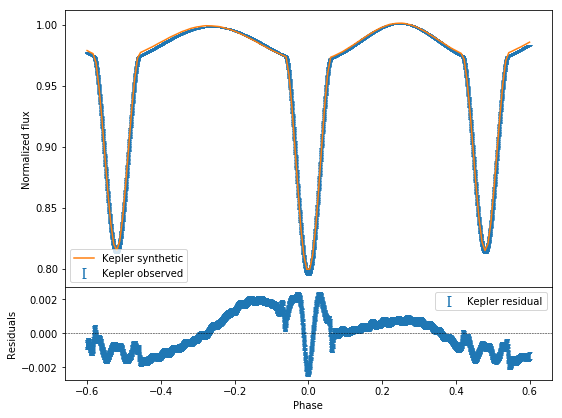

In [9]:
task.lc_fit.plot.model(discretization=10, number_of_points=150, start_phase=-0.6, stop_phase=0.6)

## Markov chain Monte Carlo (MCMC)

Markov chain Monte Carlo (MCMC) is also implemented for light curve fitting module and it serves similar purpose to produce a reliable error estimates on your eclipsing binary parameters. Since this method supports parallel approach, we can change our approach to paralelism by changing few config variables since it turns out to be much more efficient to parallelize the process on the level of the MCMC method itself:

In [10]:
config.NUMBER_OF_PROCESSES = 1  # we want a single process approach on the light curve integration level
config.NUMBER_OF_MCMC_PROCESSES = os.cpu_count()

Least squares method already found approximate position of the solution and the good coverage of the phase curve means that we can probably trust that solution and use it as a starting point for our MCMC sampling and for the reduction in the size of the search space in order to speed up the burn-in phase. Estimation on the size of the searching box for each parameter is left to user, however, the validity of the selected interval can be asserted aposteriori by studying the traces where you should avoid any clipping of your chain distribution by the borders of the searching box:

In [11]:
lc_initial = {
    'inclination': {
        'value': fit_params['inclination']['value'],
        'fixed': False,
        'min': fit_params['inclination']['value'] - 2,
        'max': fit_params['inclination']['value'] + 2
    },
    'eccentricity': {
        'value': fit_params['eccentricity']['value'],
        'fixed': False,
        'min': fit_params['eccentricity']['value'] - 0.01,
        'max': fit_params['eccentricity']['value'] + 0.01,
    },
    'mass_ratio': {
        'value': 1.077,
        'fixed': True,
    },  # value obtained during RV fit
    'argument_of_periastron': {
        'value': fit_params['argument_of_periastron']['value'],
        'fixed': False,
        'min': fit_params['argument_of_periastron']['value'] - 30,
        'max': fit_params['argument_of_periastron']['value'] + 30,
    },  
    'p__t_eff': {
        'value': 7022.0,
        'fixed': True,
    },  # fixed to value found in literature
    's__t_eff': {
        'value': fit_params['s__t_eff']['value'],
        'fixed': False,
        'min': fit_params['s__t_eff']['value'] - 100,
        'max': fit_params['s__t_eff']['value'] + 100
    },
    'p__surface_potential': {
        'value': fit_params['p__surface_potential']['value'],
        'fixed': False,
        'min': fit_params['p__surface_potential']['value'] - 0.2,
        'max': fit_params['p__surface_potential']['value'] + 0.2,
    },
    's__surface_potential': {
        'value': fit_params['s__surface_potential']['value'],
        'fixed': False,
        'min': fit_params['s__surface_potential']['value'] - 0.1,
        'max': fit_params['s__surface_potential']['value'] + 0.1,
    },
    'p__albedo': {
        'value': 1.0,
        'fixed': True
    },  
    's__albedo': {
        'value': 1.0,
        'fixed': True
    },
    'p__gravity_darkening': {
        'value': 1.0,
        'fixed': True
    },  
    's__gravity_darkening': {
        'value': 1.0,
        'fixed': True
    },  # we are presuming radiative envelopes on both components
    'semi_major_axis': {
        'constraint': '11.86 / sin(radians({inclination}))'
    },  # using parameter asin(i) obtained from RV fit
    'period': {
        'value': 2.47028376,
        'fixed': True,
    },
    'additional_light': {
        'value': fit_params['additional_light']['value'],
        'fixed': False,
        'min': fit_params['additional_light']['value'] - 0.03,
        'max': fit_params['additional_light']['value'] + 0.03,
    },  # there is strong evidence for the presence of the third body
    'phase_shift': {
        'value': fit_params['phase_shift']['value'],
        'fixed': True,
    },  # phase shift parameter was determined sufficiently in least squares method 
        # and its main purpose was to remove any imperfections in supplied phase curve or ephemeris, 
        # therefore, its error estimation is not of any significant importance to us
}

This initial vector can now be used to perform MCMC sampling:

In [14]:
param_file = 'demo_data/aux/lc_mcmc_params.json'
# fit_params = task.lc_fit.fit(x0=lc_initial, method='mcmc', nsteps=1000, burn_in=0, morphology='detached',
#                              discretization=10, interp_treshold=150, progress=True)

# task.lc_fit.store_parameters(filename=param_file)

# again, due to very time consuming nature of a MCMC sampling, we will load pre-calculated results
chain_file = 'demo_data/aux/lc_mcmc_chain.json'
task.lc_fit.load_parameters(filename=param_file)
task.lc_fit.load_chain(filename=chain_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/miro/.elisa/demo_data/demo_data/aux/lc_mcmc_chain.json'

With `burn_in` parameter 0 we have to inspect traces not only for any sign of clipping but also we have to determine how big portion of the chain belongs to the thermalization state and has to be discarded:

In [ ]:
task.lc_fit.plot.traces()

Here we can see that chain reaches sampling phase after roughly <insert value> steps. Therefore, we have to discard the first <insert value> steps by using `discard` argument:

In [ ]:
task.lc_fit.load_chain(filename=chain_file, discard=0)